# Named Entity Recognition using a BiLSTM-CRF model

Named Entity Recognition (NER) is an NLP problem, which involves locating and classifying named entities (people, places, organizations etc.) mentioned in unstructured text. This problem is used in many NLP applications that deal with use-cases like machine translation, information retrieval, chatbots and others.

The categories that the named entities are classified into are predefined and often contain entries like locations, organisations, job types, personal names, times and others.

An example of unstructured text presented to an NER system could be:

"President Joe Biden visits Europe in first presidential overseas trip"

After processing the input, a NER model could output something like this:

President <sub>Title</sub> Biden <sub>Name</sub> visits Europe <sub>Geography</sub> in first presidential overseas trip.

In this notebook we cover the process building a statistical NER model, using the freely available [Annotated Corpus for Named Entity Recognition](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). This dataset is based on the GMB (Groningen Meaning Bank) corpus, and has been tagged, annotated and built specifically to train a classifier to predict named entities such as name, location, etc. The tags used in the dataset follow the [IOB format](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)).

In [1]:
!sudo pip install plot_keras_history
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-djaa631r
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-djaa631r
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101065 sha256=d3d18e5f6365da55d8062b302a002f7d1b39cb7c33989021841d9537d18d4998
  Stored in directory: /tmp/pip-ephem-wheel-cache-cthcdflv/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


## Data ingestion and exploration

In [2]:
import pickle
import operator 
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from keras_contrib.utils import save_load_utils

from keras import layers 
from keras import optimizers

from keras.models import Model
from keras.models import Input

from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics

Using TensorFlow backend.


We start by reading the annotated dataset.

In [3]:
data_df = pd.read_csv("dataset/ner_dataset.csv", encoding="iso-8859-1", header=0)
data_df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


The meaning of the attributes is as follows:
* Sentence # - sentence ID
* Word - contains all words that form individual sentences
* POS - Part of Speech tag for each word, as defined in the [Penn Treebank tagset](https://www.sketchengine.eu/penn-treebank-tagset/)
* Tag - IOB tag for each word

Looking at the data, we see that the sentence ID is given only once per sentence (with the first word of the chunk), and the remaining values for "Sentence #" attribute are set to NaN. We'll remedy this by repeating the ID for all remaining words, so that we can calculate meaningful statistics.

In [4]:
data_df = data_df.fillna(method="ffill")
data_df["Sentence #"] = data_df["Sentence #"].apply(lambda s: s[9:])
data_df["Sentence #"] = data_df["Sentence #"].astype("int32")
data_df.head()

,Sentence #,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O


Now let's calculate some statistics about the data.

In [5]:
print("Total number of sentences in the dataset: {:,}".format(data_df["Sentence #"].nunique()))
print("Total words in the dataset: {:,}".format(data_df.shape[0]))

Total number of sentences in the dataset: 47,959
Total words in the dataset: 1,048,575


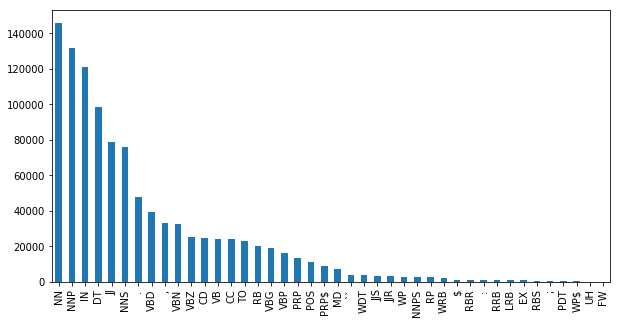

In [6]:
data_df["POS"].value_counts().plot(kind="bar", figsize=(10,5));

We notice that the top 5 parts of speech in the corpus are:
* NN - noun (e.g. table)
* NNP - proper noun (e.g. John)
* IN - preposition (e.g. in, of, like)
* DT - determiner (the)
* JJ - adjective (e.g. green)

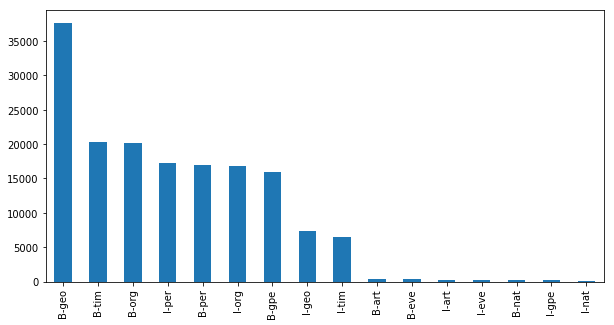

In [7]:
data_df[data_df["Tag"]!="O"]["Tag"].value_counts().plot(kind="bar", figsize=(10,5));

Based on the plot above we learn that many of our sentences start with a geography, time, organisation, or a person.

We can now look at the distribution of words per sentence.

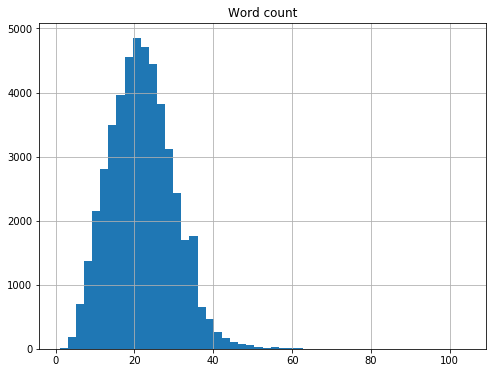

In [8]:
word_counts = data_df.groupby("Sentence #")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6));

We see that the average sentence in the dataset contains about 21-22 words.

In [9]:
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))

Longest sentence in the corpus contains 104 words.


In [10]:
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_SENTENCE].index[0]
print("ID of the longest sentence is {}.".format(longest_sentence_id))

ID of the longest sentence is 22480.


In [11]:
longest_sentence = data_df[data_df["Sentence #"]==longest_sentence_id]["Word"].str.cat(sep=' ')
print("The longest sentence in the corpus is:\n")
print(longest_sentence)

The longest sentence in the corpus is:

Fisheries in 2006 - 7 landed 1,26,976 metric tons , of which 82 % ( 1,04,586 tons ) was krill ( Euphausia superba ) and 9.5 % ( 12,027 tons ) Patagonian toothfish ( Dissostichus eleginoides - also known as Chilean sea bass ) , compared to 1,27,910 tons in 2005 - 6 of which 83 % ( 1,06,591 tons ) was krill and 9.7 % ( 12,396 tons ) Patagonian toothfish ( estimated fishing from the area covered by the Convention of the Conservation of Antarctic Marine Living Resources ( CCAMLR ) , which extends slightly beyond the Southern Ocean area ) .


In [12]:
all_words = list(set(data_df["Word"].values))
all_tags = list(set(data_df["Tag"].values))

print("Number of unique words: {}".format(data_df["Word"].nunique()))
print("Number of unique tags : {}".format(data_df["Tag"].nunique()))

Number of unique words: 35178
Number of unique tags : 17


## Feature Engineering

Now that we are slightly more familiar with the data, we can proceed with implementing the necessary feature engineering. The first step is to build a dictionary (word2index) that assigns a unique integer value to every word from the corpus. We also construct a reversed dictionary that maps numbers to words (index2word).

In [13]:
word2index = {word: idx + 2 for idx, word in enumerate(all_words)}
word2index["--UNKNOWN_WORD--"]=0
word2index["--PADDING--"]=1

index2word = {idx: word for word, idx in word2index.items()}

Let's look at the first 10 entries in the dictionary. Note, that we have included 2 extra entries at the start - one for unknown words and one for padding.

In [14]:
for k,v in sorted(word2index.items(), key=operator.itemgetter(1))[:10]:
    print(k,v)

--UNKNOWN_WORD-- 0
--PADDING-- 1
truck 2
87.61 3
HAMSAT 4
gene 5
Notre 6
Samaraweera 7
Frattini 8
nine-member 9


Let's confirm that the word-to-index and index-to-word mapping works as expected. 

In [15]:
test_word = "Scotland"

test_word_idx = word2index[test_word]
test_word_lookup = index2word[test_word_idx]

print("The index of the word {} is {}.".format(test_word, test_word_idx))
print("The word with index {} is {}.".format(test_word_idx, test_word_lookup))

The index of the word Scotland is 15147.
The word with index 15147 is Scotland.


In [16]:
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0

index2tag = {idx: word for word, idx in tag2index.items()}

Next, we write a custom function that will iterate over a sentence, and form a tuple consisting of each token, the part of speech the token represents, and its tag. We apply this function to the entire dataset and then see what the transformed version of the first sentence in the corpus looks like.

In [17]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = data_df.groupby("Sentence #").apply(to_tuples).tolist()

sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

We use this transformed dataset to extract the features (X) and labels (y) for the model. We can see what the first entries in X and y look like, after the two have been populated with words and tags. We can discard the part of speech data, as it is not needed for this specific implementation.

In [18]:
X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
y[0]: ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


We also need to replace each word with its corresponding index from the dictionary.

In [19]:
X = [[word2index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [19995, 10613, 3166, 12456, 20212, 9200, 27, 24381, 28637, 2438, 4123, 7420, 34783, 18714, 14183, 2438, 26166, 10613, 29344, 1617, 10068, 12996, 26619, 14571]
y[0]: [17, 17, 17, 17, 17, 17, 4, 17, 17, 17, 17, 17, 4, 17, 17, 17, 17, 17, 13, 17, 17, 17, 17, 17]


We see that the dataset has now been indexed. We also need to pad each sentence to the maximal sentence length in the corpus, as the LSTM model expects a fixed length input. This is where the extra "--PADDING--" key in the dictionary comes into play.

In [20]:
X = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X]
y = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]

In [21]:
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [19995, 10613, 3166, 12456, 20212, 9200, 27, 24381, 28637, 2438, 4123, 7420, 34783, 18714, 14183, 2438, 26166, 10613, 29344, 1617, 10068, 12996, 26619, 14571, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [17, 17, 17, 17, 17, 17, 4, 17, 17, 17, 17, 17, 4, 17, 17, 17, 17, 17, 13, 17, 17, 17, 17, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


The last transformation we need to perform is to one-hot encode the labels.

In [22]:
TAG_COUNT = len(tag2index)
y = [ np.eye(TAG_COUNT)[sentence] for sentence in y]

print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [19995, 10613, 3166, 12456, 20212, 9200, 27, 24381, 28637, 2438, 4123, 7420, 34783, 18714, 14183, 2438, 26166, 10613, 29344, 1617, 10068, 12996, 26619, 14571, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


Finally, we split the resulting dataset into a training and hold-out set, so that we can measure the performance of the classifier on unseen data.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

print("Number of sentences in the training dataset: {}".format(len(X_train)))
print("Number of sentences in the test dataset    : {}".format(len(X_test)))

Number of sentences in the training dataset: 43163
Number of sentences in the test dataset    : 4796


We can also convert everything into NumPy arrays, as this makes feeding the data to the model simpler.

In [24]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## Modelling

We start by calculating the maximal word length. We also set the following model hyperparameters:

* DENSE_EMBEDDING - Dimension of the dense embedding
* LSTM_UNITS - Dimensionality of the LSTM output space
* LSTM_DROPOUT - Fraction of the LSTM units to drop for the linear transformation of the recurrent state
* DENSE_UNITS - Number of fully connected units for each temporal slice
* BATCH_SIZE - Number of samples in a training batch
* MAX_EPOCHS - Maximum number of training epochs

In [25]:
WORD_COUNT = len(index2word)

DENSE_EMBEDDING = 50
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 5

We proceed by defining the architecture of the model. We add an input layer, an embedding layer (to transform the indexes into dense vectors, an bidirectional LSTM layer, and a time-distributed layer (to apply the dense output layer to each temporal slice). We then pipe this to a CRF layer, and finally construct the model by defining its input as the input layer and its output as the output of the CRF layer.

We also set a loss function and specify "accuracy" as the metric that we'll be monitoring. The optimiser is set to Adam with a learning rate of 0.001.

In [26]:
input_layer = layers.Input(shape=(MAX_SENTENCE,))
model = layers.Embedding(WORD_COUNT, DENSE_EMBEDDING, embeddings_initializer="uniform", 
                         input_length=MAX_SENTENCE)(input_layer)
model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(model)
model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"))(model)

crf_layer = CRF(units=TAG_COUNT)
output_layer = crf_layer(model)

ner_model = Model(input_layer, output_layer)

loss = losses.crf_loss
acc_metric = metrics.crf_accuracy

opt = optimizers.Adam(lr=0.001)

ner_model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
ner_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 104, 50)           1759000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 100)          40400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 100)          10100     
_________________________________________________________________
crf_1 (CRF)                  (None, 104, 18)           2178      
Total params: 1,811,678
Trainable params: 1,811,678
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_split=0.1, verbose=2)


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
 - 117s - loss: 0.4906 - crf_accuracy: 0.8804 - val_loss: 0.1613 - val_crf_accuracy: 0.9666
Epoch 2/5
 - 115s - loss: 0.1438 - crf_accuracy: 0.9673 - val_loss: 0.1042 - val_crf_accuracy: 0.9679
Epoch 3/5
 - 115s - loss: 0.0746 - crf_accuracy: 0.9765 - val_loss: 0.0579 - val_crf_accuracy: 0.9825
Epoch 4/5
 - 115s - loss: 0.0451 - crf_accuracy: 0.9868 - val_loss: 0.0390 - val_crf_accuracy: 0.9889
Epoch 5/5
 - 115s - loss: 0.0314 - crf_accuracy: 0.9909 - val_loss: 0.0316 - val_crf_accuracy: 0.9908


## Evaluation and test

We can inspect the loss and accuracy plots from the model training. They both look acceptable and it doesn't appear that the model is overfitting.

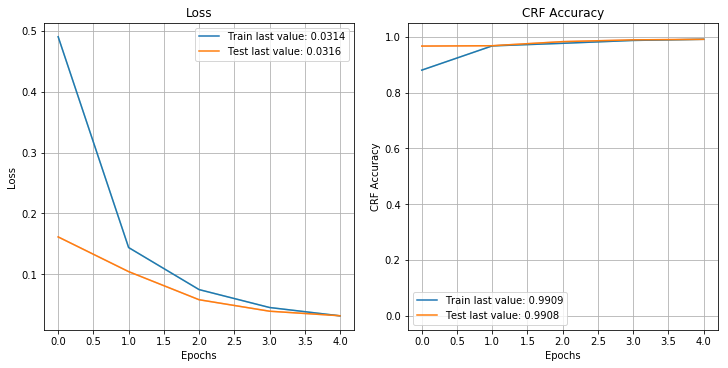

In [29]:
plot_history(history.history);

In [30]:
y_pred = ner_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(y_test, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.4f}\n".format(accuracy))

Accuracy: 0.9905



It appears that the model is doing quite well, however this is slightly misleading. This is a highly imbalanced dataset because of the very high number of O-tags that are present in the training and test data. There is further imbalance between the samples including the various tag classes. A better inspection would be to construct confusion matrices for each tag and judge the model performance based on those. We can construct a simple Python function to assist with inspection of the confusion matrices for individual tags.

In [31]:
def tag_conf_matrix(cm, tagid):
    tag_name = index2tag[tagid]
    print("Tag name: {}".format(tag_name))
    print(cm[tagid])
    tn, fp, fn, tp = cm[tagid].ravel()
    tag_acc = (tp + tn) / (tn + fp + fn + tp)
    print("Tag accuracy: {:.3f} \n".format(tag_acc))
    
matrix = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())

tag_conf_matrix(matrix, 8)
tag_conf_matrix(matrix, 14)

Tag name: B-per
[[496974    185]
 [   441   1184]]
Tag accuracy: 0.999 

Tag name: I-art
[[498750      0]
 [    34      0]]
Tag accuracy: 1.000 



Finally, we run a manual test by constructing a sample sentence and getting predictions for the detected entities. We tokenize, pad, and convert all words to indices. Then we call the model and print the predicted tags.

In [35]:
sentence = "President Obama became the first sitting American president to visit Hiroshima"

re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
sentence = re_tok.sub(r' \1 ', sentence).split()

padded_sentence = sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence))
padded_sentence = [word2index.get(w, 0) for w in padded_sentence]

pred = ner_model.predict(np.array([padded_sentence]))
pred = np.argmax(pred, axis=-1)

retval = ""
for w, p in zip(sentence, pred[0]):
    retval = retval + "{:15}: {:5}".format(w, index2tag[p]) + "\n"

print(retval)

President      : B-per
Obama          : I-per
became         : O    
the            : O    
first          : O    
sitting        : O    
American       : B-gpe
president      : O    
to             : O    
visit          : O    
Hiroshima      : B-geo

